<a href="https://colab.research.google.com/github/lmlima/nCov2019_analysis/blob/master/src/international_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
! git clone https://github.com/jianxu305/nCov2019_analysis/
#! git pull

fatal: destination path 'nCov2019_analysis' already exists and is not an empty directory.


In [0]:
import sys
import os
os.chdir('/content/nCov2019_analysis/src')

sys.path.append('/content/nCov2019_analysis/src')

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils   # some convenient functions
import matplotlib.font_manager as mfm
import datetime

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# dxy_raw = utils.load_chinese_data()

In [0]:
# dxy_frm = utils.aggDaily(dxy_raw)

In [0]:
jhs_raw = utils.load_jhs_raw()

In [0]:
jhs_frm = utils.jhs_daily(jhs_raw)

In [23]:
jhs_frm.tail()

,province/state,country/region,Last Update,cum_confirmed,cum_dead,cum_cured,Latitude,Longitude,update_time,update_date,new_confirmed,new_dead,new_cured
5291,United Kingdom,United Kingdom,2020-03-22T22:43:03,5683.0,281.0,65.0,55.3781,-3.4360,2020-03-22 22:43:03,2020-03-22,665.0,48.0,0.0
5292,,Uruguay,2020-03-22T11:13:20,135.0,0.0,0.0,-32.5228,-55.7658,2020-03-22 11:13:20,2020-03-22,25.0,0.0,0.0
5293,,Venezuela,2020-03-22T01:43:02,70.0,0.0,15.0,6.4238,-66.5897,2020-03-22 01:43:02,2020-03-22,0.0,0.0,15.0
5294,,Vietnam,2020-03-22T16:43:07,113.0,0.0,17.0,14.0583,108.2772,2020-03-22 16:43:07,2020-03-22,19.0,0.0,0.0
5295,,Zambia,2020-03-22T14:13:08,3.0,0.0,0.0,-13.1339,27.8493,2020-03-22 14:13:08,2020-03-22,1.0,0.0,0.0


# Compare countries after 50 cum_confirmed

In [0]:
countries=['Brazil','Italy', 'Germany', 'US', 'France', 'Spain']

jhs_50=jhs_frm[(jhs_frm['country/region'].isin(countries)) & (jhs_frm['cum_confirmed']>50)].copy()

In [0]:
brazil=jhs_50[(jhs_50['country/region']=='Brazil')].sort_values('update_date').reset_index()[['cum_confirmed','country/region']].copy()
# brazil["pais"]='Brazil'
italy=jhs_50[(jhs_50['country/region']=='Italy')].sort_values('update_date').reset_index()[['cum_confirmed','country/region']].copy()
# italy["pais"]='Italy'


In [71]:
italy

,cum_confirmed,country/region
0,62.0,Italy
1,155.0,Italy
2,229.0,Italy
3,322.0,Italy
4,453.0,Italy
5,655.0,Italy
6,888.0,Italy
7,1128.0,Italy
8,1694.0,Italy
9,2036.0,Italy


In [81]:
df=pd.concat([italy,brazil]).reset_index().copy()
df.columns


Index(['index', 'cum_confirmed', 'country/region'], dtype='object')

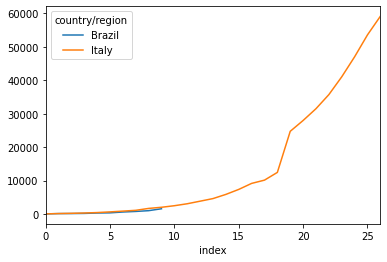

In [83]:
df = df.pivot(index='index', columns='country/region', values='cum_confirmed')

df.plot()

## 1. Sanity Check
### 1.1 Take a Brief Look at the data

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

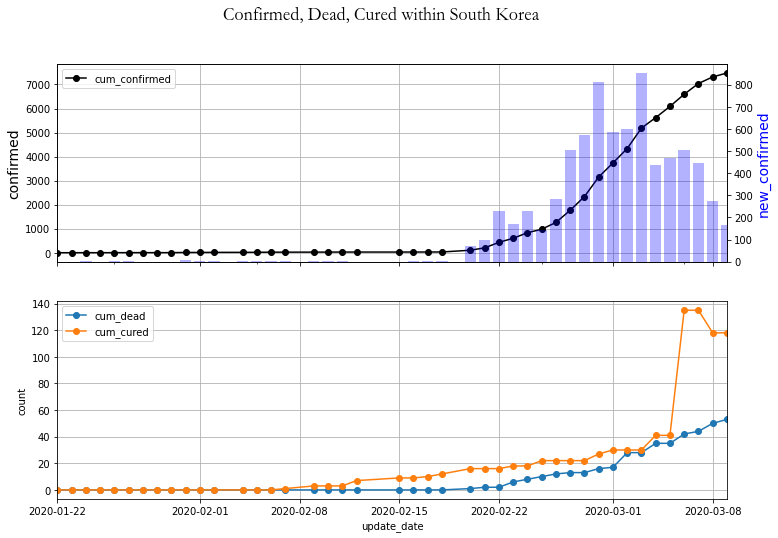

In [24]:
fig = utils.tsplot_conf_dead_cured(jhs_frm[jhs_frm['country/region'] == 'South Korea'], 
                                   title='Confirmed, Dead, Cured within South Korea', figsize=(12, 8))

## 2. Mortality Rate vs Confirmed Count

In [25]:
!pip install chart_studio

     |████████████████████████████████| 81kB 2.6MB/s 


In [0]:
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio

In [0]:
api_key  = ''  # use you own key
user_name = ''  # use your own user name
chart_studio.tools.set_credentials_file(username=user_name, api_key=api_key)

In [0]:
# most international data only has country info, so do not drill down to finer level now
country_frm = jhs_frm.groupby(['country/region', 'update_date']).agg('sum')  

### Remove Some Data Problem
Japan and US has some dates with negative new_confirm

In [29]:
country_frm[country_frm['new_confirmed'] < 0]

,,cum_confirmed,cum_dead,cum_cured,Latitude,Longitude,new_confirmed,new_dead,new_cured
country/region,update_date,,,,,,,,
Albania,2020-03-12,23.0,1.0,0.0,41.1533,20.1683,-10.0,0.0,0.0
Algeria,2020-03-12,24.0,1.0,8.0,28.0339,1.6596,-2.0,-1.0,0.0
Armenia,2020-03-12,4.0,0.0,0.0,40.0691,45.0382,-4.0,0.0,0.0
Azerbaijan,2020-03-16,15.0,1.0,6.0,40.1431,47.5769,-8.0,0.0,0.0
Belarus,2020-03-12,12.0,0.0,3.0,53.7098,27.9534,-15.0,0.0,0.0
Canada,2020-03-12,97.0,1.0,8.0,157.9204,-286.5199,-49.0,0.0,0.0
Cape Verde,2020-03-22,0.0,0.0,0.0,15.1111,-23.6167,-1.0,0.0,0.0
Costa Rica,2020-03-12,22.0,0.0,0.0,9.7489,-83.7534,-1.0,0.0,0.0
Cuba,2020-03-12,3.0,0.0,0.0,22.0000,-80.0000,-1.0,0.0,0.0


In [0]:
country_frm['new_confirmed'] = np.maximum(0, country_frm['new_confirmed'])   # Japan 1/23, 2/7, US 2/24 have new confirmed < 0, looks like data error

### Add Mortality Rate, Moving Average, etc

In [0]:
country_frm['mortality_rate'] = country_frm['cum_dead'] / country_frm['cum_confirmed']
country_frm = utils.add_moving_average(country_frm, ['country/region'], win_size=3)

In [0]:
# The following columns are mainly for plot rendering
country_frm['new_confirmed_logMA'] = np.log10(country_frm['new_confirmed_MA'] + 2)
color_countries = ['Mainland China', 'Japan', 'South Korea', 'Iran', 'Italy', 'Germany', 
                   'US', 'France', 'Spain', 'Diamond Princess', 'Thailandl', 'Taiwan', 'Hong Kong',
                   'Singapore', 'UK', 'Iraq']
country_frm['color'] = np.where(country_frm.index.get_level_values('country/region').isin(color_countries), 
                                country_frm.index.get_level_values('country/region'), 
                                'Other')
country_ex_china = country_frm[country_frm.index.get_level_values('country/region') != 'Mainland China']

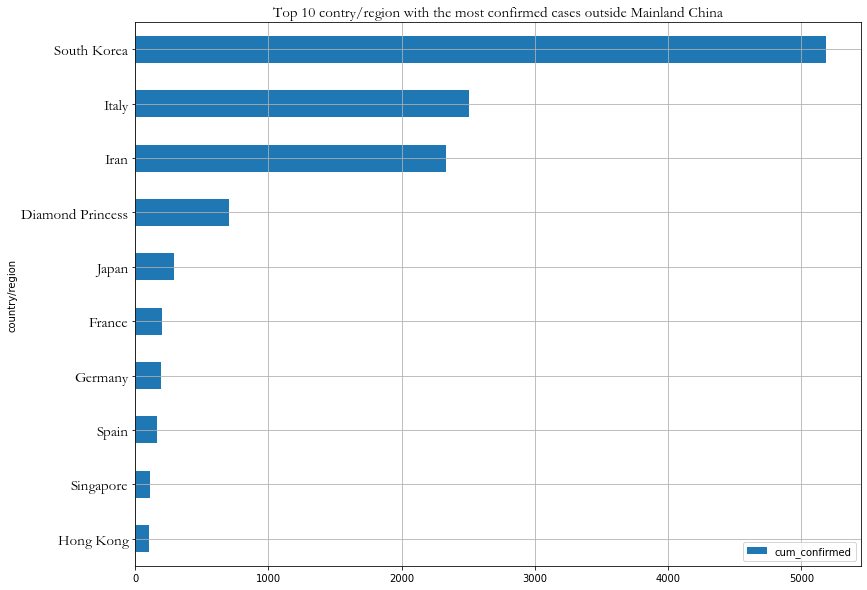

In [33]:
fig = utils.cross_sectional_bar(country_ex_china.reset_index(), '2020-03-03', 'cum_confirmed', 'country/region', 10,
                                title='Top 10 contry/region with the most confirmed cases outside Mainland China')

#### Flashback to 2020-02-26

In [34]:
date = datetime.date(2020, 2, 26)
frm = country_ex_china.loc[(slice(None), date), :].reset_index()
#frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 color='color',
                 text='country/region',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['country/region', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.01, 0.15], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.01, 0.15], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[4, 2000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[4, 2000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.update_traces(textposition='top center')

fig.show()

In [0]:
pio.write_html(fig, file='index.html', auto_open=True)

### 2020-03-02

In [39]:
date = datetime.date(2020, 3, 22)
frm = country_ex_china.loc[(slice(None), date), :].reset_index()
#frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 color='color',
                 text='country/region',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['country/region', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
fig.update_traces(textposition='top center')
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.01, 0.08], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.01, 0.08], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[20, 5000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[20, 5000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.show()

### Comparison: China has been stable in the past two weeks

In [37]:
china_frm = dxy_frm.copy()
china_frm['province_name'] = np.where(china_frm['city_name'] == '武汉', '武汉', china_frm['province_name'])  # treat Wuhan as a province
china_frm['province_name'] = np.where(china_frm['province_name'] == '湖北省', '湖北省除武汉', china_frm['province_name'])
china_province = china_frm.groupby(['province_name', 'update_date']).agg('sum')

NameError: ignored

In [0]:
china_province = utils.add_moving_average(china_province, ['province_name'], 3)
china_province['mortality_rate'] = china_province['cum_dead'] / china_province['cum_confirmed']
china_province['new_confirmed_logMA'] = np.log10(china_province['new_confirmed_MA'] + 2)

In [0]:
date = datetime.date(2020, 2, 19)
frm = china_province.loc[(slice(None), date), :].reset_index()
#frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
#frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 #color='color',
                 text='province_name',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['province_name', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[15, 50000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[15, 50000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.update_traces(textposition='top center')

fig.show()

### China on 2020-03-02, bubbles are diminishing, so spread is slowed down

In [0]:
date = datetime.date(2020, 3, 2)
frm = china_province.loc[(slice(None), date), :].reset_index()
#frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
#frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 #color='color',
                 text='province_name',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['province_name', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[50, 50000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[50, 50000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.update_traces(textposition='top center')

fig.show()